### Task
Implement a class in python that takes an image and extract keypoints and descriptors using opencv feature detection API. The class should take as a parameter the type of feature (ORB,SIFT,SURF, etc..) that should be extracted. Choose at least 4 feature options from the ones supported by opencv.  Compare the run-time of each feature extraction and description for 1000 points on the same image. (if you are feeling bold, try kornia as well)

In [1]:
import numpy as np
import cv2 as cv
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import time

In [2]:
class FeatureExtractor(ABC):
    def __init__(self, img_path, max_points):
        # Loads image to memory
        self.original_img = cv.imread(img_path)
        
        # Transforms image to grayscale
        self.gray_img = cv.cvtColor(self.original_img,cv.COLOR_BGR2GRAY)
        
        self.kp = None
        self.des = None
        self.max_points = max_points
        
    @abstractmethod
    def run(self):
        pass

    def plot_key_points(self, title):
        if self.kp is None:
            raise RuntimeError('''It's necessary to extract the features (.run method)
                                before ploting the keypoints''')
        
        key_points_img = self.original_img.copy()
        cv.drawKeypoints(self.original_img,self.kp, key_points_img)
        key_points_img = cv.cvtColor(key_points_img, cv.COLOR_BGR2RGB)
        plt.imshow(key_points_img)
        plt.title(title)
        plt.axis('off')
        plt.show()

class SIFTFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path, max_points=1000):
        super().__init__(img_path, max_points)
    
    def run(self):
        sift = cv.SIFT_create(nfeatures=self.max_points)
        self.kp, self.des = sift.detectAndCompute(self.gray_img,None)
        
        return self.kp, self.des

#Obs: The SURF Feature extractor needs a license
class SURFFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path, max_points = 1000, hessian_thresshold=400):
        super().__init__(img_path, max_points)
        self.hessian_tresshold = hessian_thresshold
    
    def run(self):
        surf = cv.xfeatures2d.SURF_create(self.hessian_tresshold,nfeatures=self.max_points)
        self.kp, self.des = surf.detectAndCompute(self.gray_img,None)

        return self.kp, self.des
    
    def set_hessian_thresshold(self, thresshold):
        self.hessian_tresshold = thresshold

class BRIEFFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path):
        super().__init__(img_path, max_points=None)
    
    def run(self):
        # Initiate FAST detector
        star = cv.xfeatures2d.StarDetector_create()
        
        # Initiate BRIEF extractor
        brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
        
        # find the keypoints with STAR
        kp = star.detect(self.gray_img,None)
        
        # compute the descriptors with BRIEF
        self.kp, self.des = brief.compute(self.gray_img, kp)

        return self.kp, self.des

class ORBFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path, max_points=1000):
        super().__init__(img_path,max_points)
    
    def run(self):
        # Initiate ORB detector
        orb = cv.ORB_create(nfeatures=self.max_points)
        
        # find the keypoints with ORB
        kp = orb.detect(self.gray_img,None)
        
        # compute the descriptors with ORB
        self.kp, self.des = orb.compute(self.gray_img, kp)

        return self.kp, self.des
    
class AKAZEFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path, max_points=1000):
        super().__init__(img_path, max_points)
    
    def run(self):
        akaze = cv.AKAZE_create(max_points=self.max_points)

        self.kp, self.des = akaze.detectAndCompute(self.gray_img, None)

        return self.kp, self.des


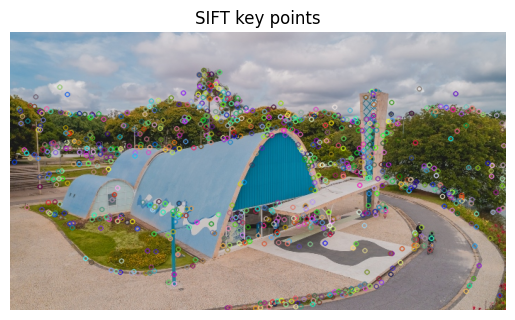

In [3]:
image_path = './data/igreja_pampulha.jpg'

fe = SIFTFeatureExtractor(image_path)
fe.run()
fe.plot_key_points('SIFT key points')

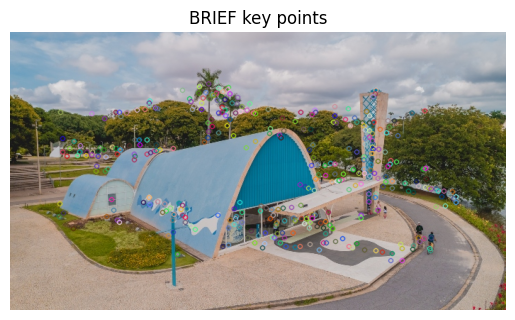

In [4]:
fe = BRIEFFeatureExtractor(image_path)
fe.run()
fe.plot_key_points('BRIEF key points')

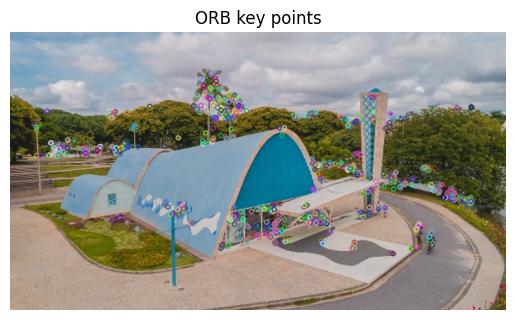

In [5]:
fe = ORBFeatureExtractor(image_path)
fe.run()
fe.plot_key_points('ORB key points')

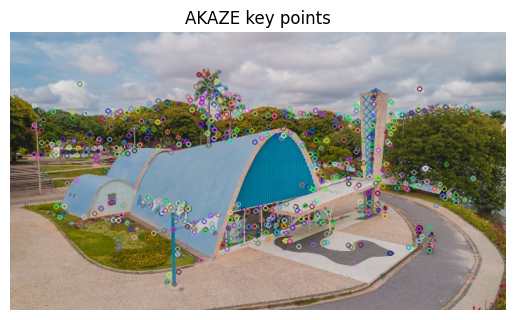

In [6]:
fe = AKAZEFeatureExtractor(image_path)
fe.run()
fe.plot_key_points('AKAZE key points')

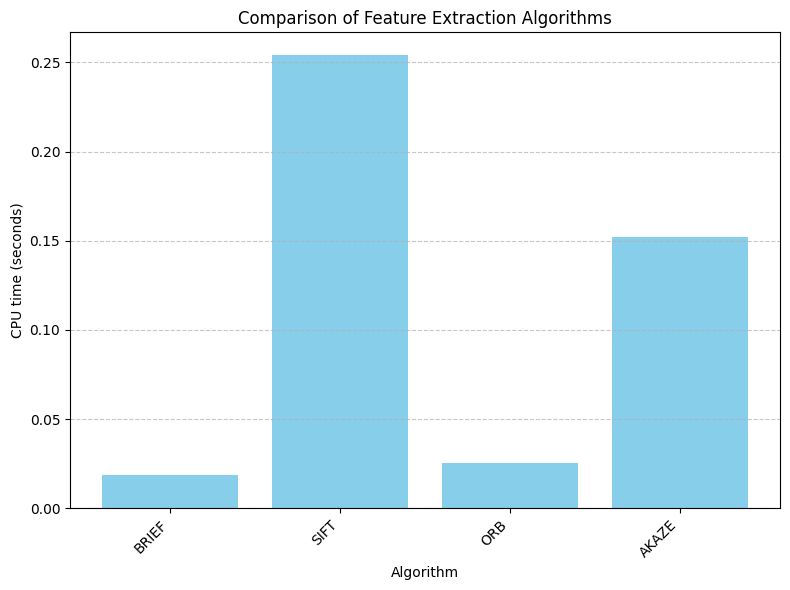

In [7]:
feature_extractors = {'BRIEF': BRIEFFeatureExtractor(image_path),
                      'SIFT': SIFTFeatureExtractor(image_path),
                      'ORB': ORBFeatureExtractor(image_path),
                      'AKAZE': AKAZEFeatureExtractor(image_path)}

running_times = {}
for fe_name, fe_object in feature_extractors.items():
    start_cpu_time = time.process_time()
    fe_object.run()
    end_cpu_time = time.process_time()
    running_times[fe_name] = end_cpu_time - start_cpu_time

names = list(running_times.keys())
values = list(running_times.values())

plt.figure(figsize=(8, 6)) # Optional: set figure size
plt.bar(names, values, color='skyblue') # Create the bar chart

plt.xlabel('Algorithm') # Label for X-axis
plt.ylabel('CPU time (seconds)')       # Label for Y-axis
plt.title('Comparison of Feature Extraction Algorithms') # Plot title
plt.grid(axis='y', linestyle='--', alpha=0.7) # Optional: add horizontal grid lines
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()        